In [1]:
from dlsr import *
import numpy as np
import os
from PIL import Image
from dlsr.data import DIV2K

In [2]:
image_size = 32
batch_size = 128
training_data_size = 6400
validation_data_size = 128
num_to_predict = 10
predict_size = 192

output_path = "./output/temp_vgg"

In [3]:
from dlsr.data.div2k import random_crop


training_data = helpers.get_training_data(
    num=training_data_size, valid_num=validation_data_size, image_size=image_size
)

callback_ds = DIV2K(type="valid").dataset(batch_size=1, random_transform=False, crop_images=True, image_size=predict_size)
callback_ds = callback_ds.map(lambda a, b: a)
callback_ds = callback_ds.take(num_to_predict)

loading validation...
finished loading validation
loading training...
finished loading training


In [4]:
def callback(generator, i):
    directory = f"{output_path}/{i}"
    try:
        os.makedirs(directory)
    except FileExistsError:
        # directory already exists
        pass

    generator.save(f"{directory}/generator.h5")

    upscaled = upscale(generator, callback_ds, batch_size=num_to_predict)

    for i , x in enumerate(upscaled):
        im = Image.fromarray(np.uint8(x))
        im.save(os.path.join(directory, f"converted{i}.png"), format="png")

In [5]:
try:
    os.makedirs(output_path)
except FileExistsError:
    # directory already exists
    pass

discriminator = models.discriminator(image_size=image_size)
generator = models.basic()
generator, gen_his, discriminator, dis_his = train_gan(
    discriminator=discriminator,
    generator=generator,
    training_data=training_data,
    epochs=50,
    discriminator_epochs=40,
    discriminator_patience=40,
    discriminator_batch_size=batch_size,
    discriminator_n=2e-6,
    generator_epochs=40,
    generator_loss_fn=losses.get_srgan_loss(discriminator)["srgan_vgg_loss"],
    generator_patience=40,
    generator_batch_size=batch_size,
    generator_n=2e-5,
    pre_train_epochs=200,
    pre_train=True,
    pre_train_loss_fn=losses.vgg_style_loss,
    epoch_start_callback=callback
)

Epoch 1/200
50/50 [==============================] - 11s 90ms/step - loss: 0.0024 - accuracy: 0.3140 - ssim_loss: 0.5776 - val_loss: 0.0022 - val_accuracy: 0.3211 - val_ssim_loss: 0.5594
Epoch 2/200
50/50 [==============================] - 4s 77ms/step - loss: 0.0019 - accuracy: 0.3221 - ssim_loss: 0.5581 - val_loss: 0.0020 - val_accuracy: 0.3221 - val_ssim_loss: 0.5494
Epoch 3/200
50/50 [==============================] - 4s 77ms/step - loss: 0.0019 - accuracy: 0.2842 - ssim_loss: 0.5536 - val_loss: 0.0020 - val_accuracy: 0.2512 - val_ssim_loss: 0.5465
Epoch 4/200
50/50 [==============================] - 4s 78ms/step - loss: 0.0019 - accuracy: 0.1691 - ssim_loss: 0.5510 - val_loss: 0.0020 - val_accuracy: 0.2507 - val_ssim_loss: 0.5445
Epoch 5/200
50/50 [==============================] - 4s 79ms/step - loss: 0.0019 - accuracy: 0.1640 - ssim_loss: 0.5493 - val_loss: 0.0020 - val_accuracy: 0.2505 - val_ssim_loss: 0.5429
Epoch 6/200
50/50 [==============================] - 4s 79ms/step - l

In [6]:
generator.save("./saved-models/srgan_vgg/generator.h5")
discriminator.save("./saved-models/srgan_vgg/discriminator.h5")

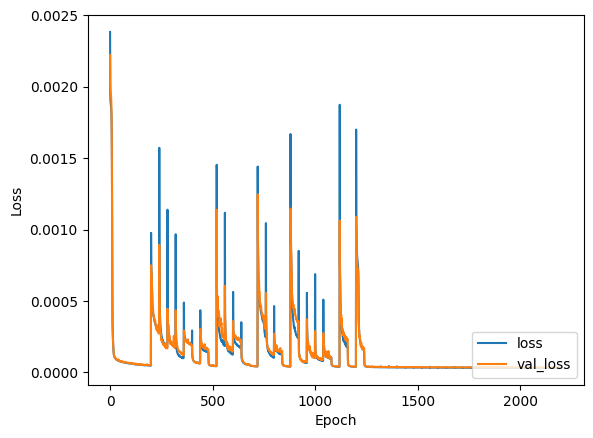

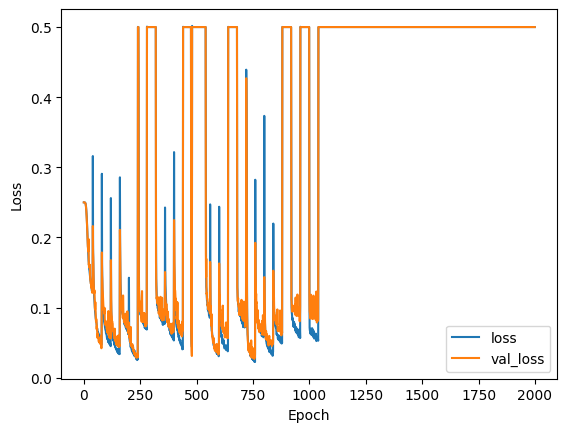

In [7]:
helpers.plot_history(gen_his)
helpers.plot_history(dis_his)